<a href="https://colab.research.google.com/github/00000281892/DynaBiome/blob/main/Self_Knowledge_Distillation_Driven_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load csv file with pandas
import pandas as pd
df_benchmark = pd.read_csv('/content/asv_interpretability_dataset_modified.csv', dtype={'PatientID': str})

In [ ]:
# --- Handle NeutrophilCount with '<0.1' values ---
def parse_neutrophil(value):
    try:
        return float(value)
    except:
        if isinstance(value, str) and "<" in value:
            threshold = float(value.replace("<", "").strip())
            return threshold / 2  # or use threshold itself
        return np.nan

df_benchmark['NeutrophilCount'] = df_benchmark['NeutrophilCount'].apply(parse_neutrophil)

In [ ]:
# One-hot encode stool consistency
df_benchmark = pd.get_dummies(df_benchmark, columns=['Consistency'])

In [ ]:
# Log transform Genus-relative abundances
df_benchmark['RelativeAbundance'] = df_benchmark['RelativeAbundance'].astype(float)
df_benchmark['RelativeAbundance'] = np.log1p(df_benchmark['RelativeAbundance'])

In [ ]:
def label_dysbiosis(row):
    is_temp_abnormal = row['MaxTemperature'] > 38.0
    is_neutro_low = row['NeutrophilCount'] < 500
    is_consistency_liquid = row.get('Consistency_liquid', 0) == 1
    return int(is_temp_abnormal and is_neutro_low and is_consistency_liquid)

In [ ]:
df_benchmark['DysbiosisLabel'] = df_benchmark.apply(label_dysbiosis, axis=1)

In [ ]:
# Keep metadata along with abundances
metadata_cols = ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                 'MaxTemperature', 'NeutrophilCount'] + \
                [col for col in df_benchmark.columns if col.startswith('Consistency_')] + \
                ['DysbiosisLabel']

In [ ]:
genus_pivot = df_benchmark.pivot_table(
    index=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'],
    columns='Genus',
    values='RelativeAbundance',
    fill_value=0
).reset_index()

In [ ]:
# Merge with metadata
metadata = df_benchmark[metadata_cols].drop_duplicates(subset=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'])
merged_df_benchmark = pd.merge(genus_pivot, metadata, on=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'], how='left')

In [ ]:
# Drop genus columns with zero variance
genus_cols = df_benchmark['Genus'].unique().tolist()
variances = merged_df_benchmark[genus_cols].var()
non_zero_var_cols = variances[variances > 1e-6].index.tolist()

In [ ]:
# Final feature set
feature_cols = non_zero_var_cols + ['MaxTemperature', 'NeutrophilCount'] + \
               [col for col in merged_df_benchmark.columns if 'Consistency' in col]

In [ ]:
# ==================== STEP 2: Scaling ====================
scaler = MinMaxScaler()
merged_df_benchmark[feature_cols] = scaler.fit_transform(merged_df_benchmark[feature_cols])

In [ ]:
# ==================== STEP 3: Prepare Time Series ====================
# Sort & reshape by patient and day
merged_df_benchmark = merged_df_benchmark.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

In [ ]:
# --- [1] Build sequences with labels ---
def build_sequences_with_labels(df, feature_cols, label_col='DysbiosisLabel', seq_len=14):
    X_sequences = []
    y_labels = []
    time_indices = []

    for pid, group in df.groupby('PatientID'):
        group = group.sort_values('DayRelativeToNearestHCT')
        values = group[feature_cols].values
        labels = group[label_col].values
        days = group['DayRelativeToNearestHCT'].values

        for i in range(len(values) - seq_len + 1):
            seq = values[i:i+seq_len]
            label_window = labels[i:i+seq_len]
            label = int(label_window.max())  # 1 if any point in window is dysbiotic
            time = days[i+seq_len-1]  # assign the last day of the window
            X_sequences.append(seq)
            y_labels.append(label)
            time_indices.append((pid, time))

    return np.array(X_sequences), np.array(y_labels), time_indices

In [ ]:
# --- [2] Define features ---
seq_len = 14
feature_cols = [col for col in merged_df_benchmark.columns
                if col not in ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                               'DysbiosisLabel', 'MaxTemperature', 'NeutrophilCount']
                and not col.startswith('Consistency_')]

# --- [3] Build sequences ---
X_seq, y_seq, time_idx = build_sequences_with_labels(merged_df_benchmark, feature_cols, seq_len=seq_len)

In [ ]:
# --- [4] Create DataFrame for temporal splitting ---
split_df = pd.DataFrame(time_idx, columns=['PatientID', 'DayRelativeToNearestHCT'])
split_df['y'] = y_seq
split_df['X_idx'] = range(len(X_seq))

In [ ]:
# --- [5] Sort by patient and time ---
split_df = split_df.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

In [ ]:
# --- [6] Determine split indices (70/15/15 by number of sequences) ---
n_total = len(split_df)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

In [ ]:
train_idx = split_df.iloc[:n_train]['X_idx'].values
val_idx = split_df.iloc[n_train:n_train+n_val]['X_idx'].values
test_idx = split_df.iloc[n_train+n_val:]['X_idx'].values

In [ ]:
# --- [7] Final splits ---
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val, y_val = X_seq[val_idx], y_seq[val_idx]
X_test, y_test = X_seq[test_idx], y_seq[test_idx]

In [ ]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (49781, 14, 412), Validation: (10667, 14, 412), Test: (10669, 14, 412)


In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, LSTM, Dense,
                                     Dropout, GlobalAveragePooling1D, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# ----- Custom Layer to compute KL divergence and attach loss -----
class KLDivergenceLayer(tf.keras.layers.Layer):
    def __init__(self, weight=0.1, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)
        self.weight = weight

    def call(self, inputs):
        main_pred, branch_pred = inputs
        epsilon = 1e-7
        main_pred = tf.clip_by_value(main_pred, epsilon, 1.0)
        branch_pred = tf.clip_by_value(branch_pred, epsilon, 1.0)
        # Compute the KL divergence loss between the two predictions.
        # (Note: for binary probabilities from a sigmoid, KL divergence might be less common,
        # but here it serves to align the two outputs.)
        kl_loss = tf.reduce_mean(tf.keras.losses.kld(main_pred, branch_pred))
        self.add_loss(self.weight * kl_loss)
        # Return the inputs unchanged (or you could return one of them)
        return inputs


timesteps = X_train.shape[1]   # e.g. 14
n_features = X_train.shape[2]  # e.g. 412

# ----- Model Definition: CNN-LSTM with Self-Knowledge Distillation -----
inp = Input(shape=(timesteps, n_features), name='input_layer')

# --- CNN Module ---
# This layer extracts local feature patterns from our sequential data.
cnn_out = Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same',
                 name='conv1d')(inp)

# --- Self-Distillation Branch (Shallow Classifier) ---
# Extract a global representation from the CNN output with GlobalAveragePooling1D.
branch_features = GlobalAveragePooling1D(name='global_avg_pool')(cnn_out)
branch_output = Dense(1, activation='sigmoid', name='branch_output')(branch_features)

# --- Continue with Main Pipeline ---
# Use a pooling layer to reduce the sequence length.
pool_out = MaxPooling1D(pool_size=2, padding='same', name='max_pool')(cnn_out)
# Pass the pooled features through an LSTM to learn temporal dependencies.
lstm_out = LSTM(100, return_sequences=False, name='lstm')(pool_out)
dense_out = Dense(64, activation='relu', name='dense')(lstm_out)
drop = Dropout(0.3, name='dropout')(dense_out)
main_output = Dense(1, activation='sigmoid', name='main_output')(drop)

# --- Attach the KL Divergence Loss using the custom layer ---
# This layer takes both the main and branch predictions,
# computes a scaled KL divergence, and adds it as an extra loss.
_ = KLDivergenceLayer(weight=0.1, name='kl_layer')([main_output, branch_output])

# Build the model with two outputs; both outputs will be trained using the ground truth.
model = Model(inputs=inp, outputs=[main_output, branch_output], name='CNN_LSTM_SKD')

# ----- Compile the Model -----
# Both outputs use binary crossentropy.
# We assign a higher weight to the main output.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'main_output': 'binary_crossentropy',
                    'branch_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1.0, 'branch_output': 0.5},
              metrics={'main_output': 'accuracy', 'branch_output': 'accuracy'})

model.summary()

# ----- Training the Model -----
# Because our model produces two outputs, we supply the same ground-truth labels for both outputs.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    {'main_output': y_train, 'branch_output': y_train},
                    validation_data=(X_val, {'main_output': y_val, 'branch_output': y_val}),
                    epochs=300,
                    batch_size=64,
                    callbacks=[early_stopping])

# ----- Evaluate on Test Set -----
results = model.evaluate(X_test, {'main_output': y_test, 'branch_output': y_test})
print(f"Test Loss & Metrics: {results}")

Model: "CNN_LSTM_SKD"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 412)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 14, 64)    │     79,168 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool            │ (None, 7, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     66,000 │ max_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │         65 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_output       │ (None, 1)         │         65 │ global_avg_pool[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 151,762 (592.82 KB)

 Trainable params: 151,762 (592.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
778/778 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - branch_output_accuracy: 0.8052 - branch_output_loss: 0.5533 - loss: 0.6228 - main_output_accuracy: 0.8506 - main_output_loss: 0.3462 - val_branch_output_accuracy: 0.8021 - val_branch_output_loss: 0.4015 - val_loss: 0.5415 - val_main_output_accuracy: 0.8308 - val_main_output_loss: 0.3406
Epoch 2/300
778/778 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - branch_output_accuracy: 0.8460 - branch_output_loss: 0.3324 - loss: 0.3753 - main_output_accuracy: 0.8951 - main_output_loss: 0.2091 - val_branch_output_accuracy: 0.8182 - val_branch_output_loss: 0.3739 - val_loss: 0.5338 - val_main_output_accuracy: 0.8178 - val_main_output_loss: 0.3468
Epoch 3/300
778/778 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - branch_output_accuracy: 0.8521 - branch_output_loss: 0.3157 - loss: 0.3389 - main_output_accuracy: 0.9129 - main_output_loss: 0.1811 - val_branch_output_accuracy: 0.8236 - val_branch_output_loss: 0.3637 - val_loss: 0.5709 - val_main_output_accuracy: 0.8

334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      6159
           1       0.65      0.79      0.71      4510

    accuracy                           0.73     10669
   macro avg       0.73      0.74      0.73     10669
weighted avg       0.74      0.73      0.73     10669

=== Evaluation Metrics ===
Precision: 0.6457
Recall: 0.7871
F1 Score: 0.7094
ROC AUC: 0.8301
Matthews Corr. Coefficient (MCC): 0.4654


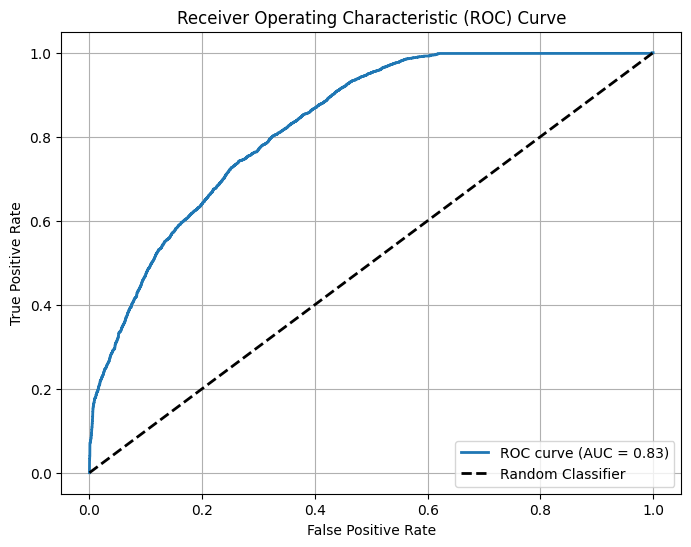

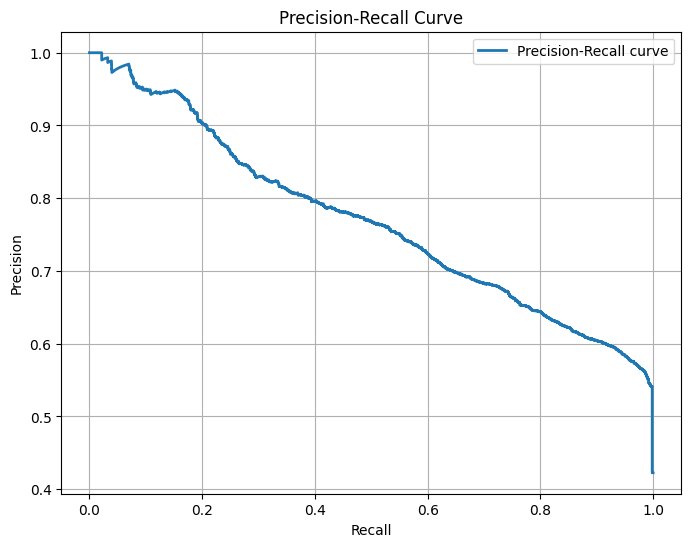

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef)

# ------------------------------------------------------------------
# STEP 1: Generate Predictions on the Test Set
# ------------------------------------------------------------------
# Note:
#   The model produces two outputs [main_output, branch_output]. For evaluation,
#   we use the main output.
predictions = model.predict(X_test)
y_pred_proba = predictions[0].flatten()  # main output probabilities
y_pred_class = (y_pred_proba > 0.5).astype(int)  # threshold at 0.5

# ------------------------------------------------------------------
# STEP 2: Compute Evaluation Metrics
# ------------------------------------------------------------------
# Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_class))

# Individual Metrics
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred_class)

print("=== Evaluation Metrics ===")
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Matthews Corr. Coefficient (MCC): {:.4f}".format(mcc))

# ------------------------------------------------------------------
# STEP 3: Plot ROC Curve
# ------------------------------------------------------------------
fpr, tpr, thr_roc = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png', dpi=600, bbox_inches='tight')
plt.show()

# ------------------------------------------------------------------
# STEP 4: Plot Precision-Recall Curve
# ------------------------------------------------------------------
prec_vals, recall_vals, thr_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, prec_vals, label="Precision-Recall curve", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('precision_recall_curve.png', dpi=600, bbox_inches='tight')
plt.show()

=== Precision-Recall (PR) Curve AUC (Average Precision) ===
Average Precision (PR AUC): 0.7690


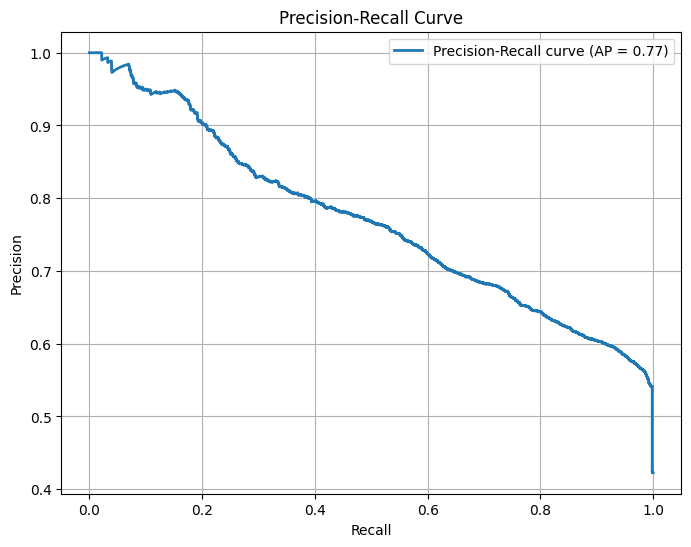

In [ ]:
# Compute PR (AUC) Curve and also print it's value.

from sklearn.metrics import average_precision_score

# Compute Average Precision (AP) Score
# This is the AUC for the Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred_proba)

print("=== Precision-Recall (PR) Curve AUC (Average Precision) ===")
print("Average Precision (PR AUC): {:.4f}".format(average_precision))

# The plotting code for the PR curve is already present in the preceding code.
# To explicitly show the AUC on the plot, we can modify the plot legend:
# (This part is already in our original code, but adding a comment to highlight)
# plt.plot(recall_vals, prec_vals, label=f'Precision-Recall curve (AP = {average_precision:.2f})', linewidth=2)
# The existing line is: plt.plot(recall_vals, prec_vals, label="Precision-Recall curve", linewidth=2)
# You might want to update it to include the AP score directly in the label like this:
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, prec_vals, label=f'Precision-Recall curve (AP = {average_precision:.2f})', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('precision_recall_curve.png', dpi=600, bbox_inches='tight')
plt.show()

334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
[[4211 1948]
 [ 960 3550]]


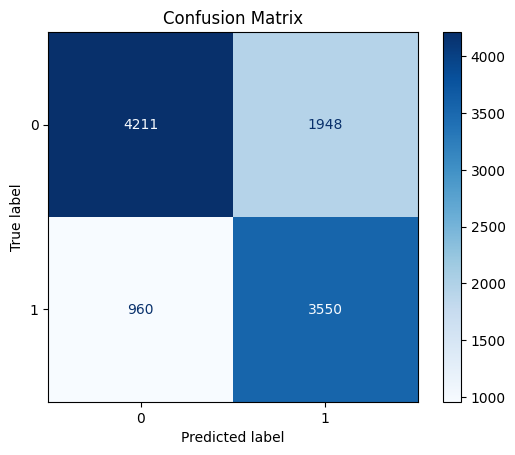

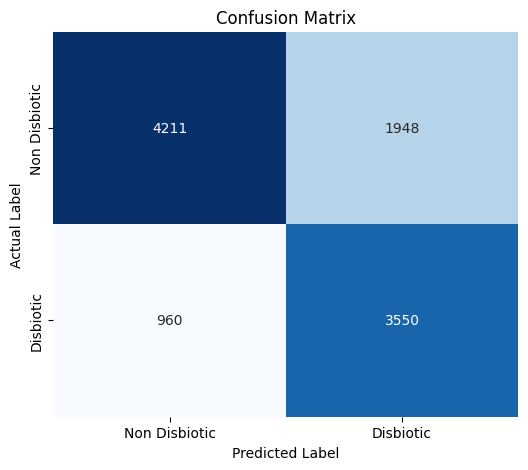

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume you already generated the main prediction probabilities on your test set:
# predictions = model.predict(X_test)
# For evaluation, we use the main_output probabilities:
y_pred_proba = model.predict(X_test)[0].flatten()    # main_output, shape (n_samples,)
y_pred_class = (y_pred_proba > 0.5).astype(int)         # threshold at 0.5 for binary classification

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Option 1: Using the built-in display method from scikit-learn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Option 2: Plotting with seaborn's heatmap for a more customizable view
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non Disbiotic', 'Disbiotic'],
            yticklabels=['Non Disbiotic', 'Disbiotic'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()
